正在读取文件：Housing_price_data.xlsx
发现以下街区（工作表）：['DAchang', 'Yizhuang', 'Majuqiao']

分析街区：DAchang
数据形状：(1200, 2)
数据列：['总价', '面积']
使用列 '总价' 作为房价列，'面积' 作为面积列
异常值数量：64 (5.33%)
每平方米中位数价格：8695.65

分析街区：Yizhuang
数据形状：(1200, 2)
数据列：['总价', '面积']
使用列 '总价' 作为房价列，'面积' 作为面积列
异常值数量：20 (1.67%)
每平方米中位数价格：58825.69

分析街区：Majuqiao
数据形状：(1200, 2)
数据列：['总价', '面积']
使用列 '总价' 作为房价列，'面积' 作为面积列
异常值数量：9 (0.75%)
每平方米中位数价格：29246.47

各街区每平方米中位数价格：
         街区     每平方米中位数价格
0   DAchang   8695.652174
1  Yizhuang  58825.692121
2  Majuqiao  29246.473219

图表已保存为'各街区房屋价格.png'
分析结果已保存为'housing_analysis_results.xlsx'


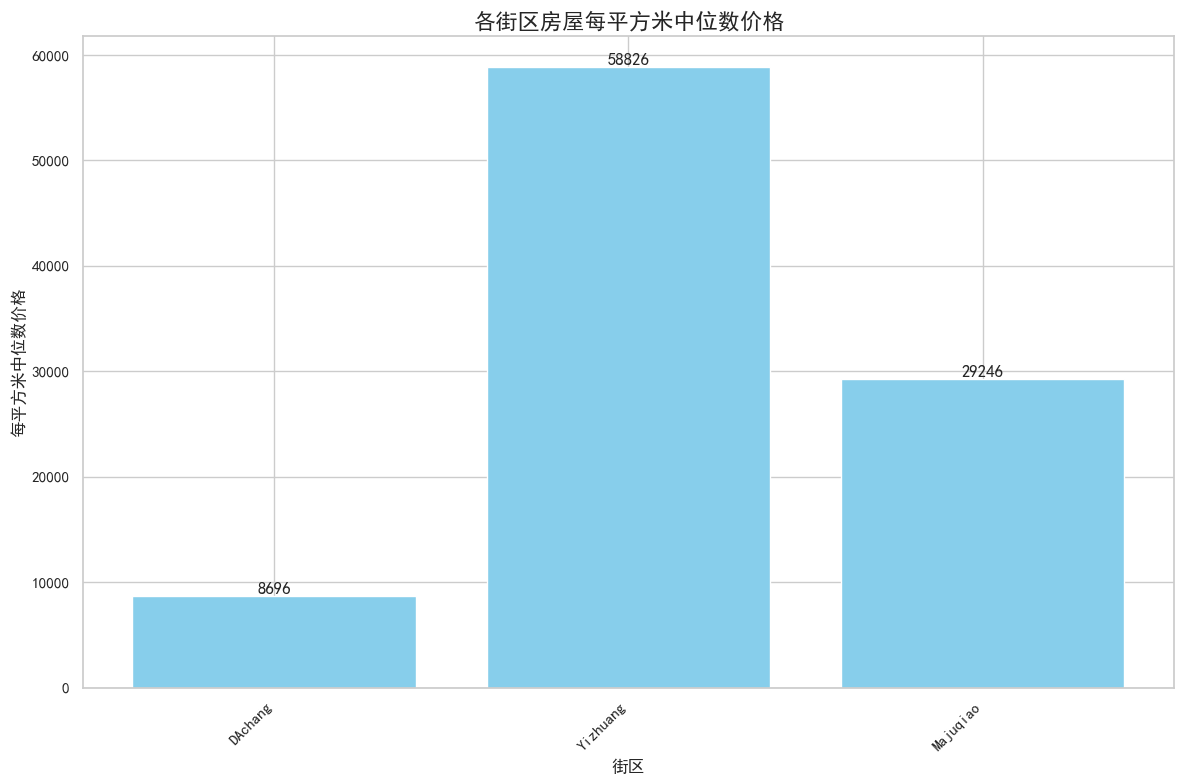

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from openpyxl import load_workbook

# 设置中文字体
sns.set(font='SimHei', style='whitegrid')
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 文件路径
file_path = "Housing_price_data.xlsx"

# 检查文件是否存在
if not os.path.exists(file_path):
    print(f"错误：找不到文件 {file_path}")
    exit()

print(f"正在读取文件：{file_path}")

# 读取Excel文件中的所有工作表名称
workbook = load_workbook(file_path, read_only=True)
blocks = workbook.sheetnames
workbook.close()

print(f"发现以下街区（工作表）：{blocks}")

# 创建结果存储字典
results = {
    'block': [],
    'median_price_per_m2': [],
    'data_description': [],
    'outliers_info': []
}

# 分析每个街区的数据
for block in blocks:
    print(f"\n分析街区：{block}")
    
    # 读取工作表数据
    df = pd.read_excel(file_path, sheet_name=block)
    
    # 数据描述
    data_desc = df.describe()
    print(f"数据形状：{df.shape}")
    print(f"数据列：{df.columns.tolist()}")
    
    # 识别总价和面积列
    price_columns = [col for col in df.columns if '总价' in str(col) or 'price' in str(col).lower()]
    area_columns = [col for col in df.columns if '面积' in str(col) or 'area' in str(col).lower()]
    
    if not price_columns:
        print(f"警告：在工作表 {block} 中未找到房价相关列")
        continue
    
    if not area_columns:
        print(f"警告：在工作表 {block} 中未找到面积相关列")
        continue
    
    price_col = price_columns[0]
    area_col = area_columns[0]
    
    print(f"使用列 '{price_col}' 作为房价列，'{area_col}' 作为面积列")
    
    # 处理带单位的价格数据（如"83万"）
    def convert_price(value):
        try:
            if isinstance(value, str):
                # 移除可能的逗号
                value = value.replace(',', '').strip()
                # 检查是否包含'万'单位
                if '万' in value:
                    # 提取数字部分并乘以10000
                    num_part = value.replace('万', '').strip()
                    return float(num_part) * 10000
                else:
                    return float(value)
            return float(value)
        except (ValueError, TypeError):
            return None
    
    # 处理带单位的面积数据（如"116㎡"）
    def convert_area(value):
        try:
            if isinstance(value, str):
                # 移除可能的逗号和面积单位
                value = value.replace(',', '').replace('㎡', '').strip()
                return float(value)
            return float(value)
        except (ValueError, TypeError):
            return None
    
    # 应用转换函数
    df[price_col] = df[price_col].apply(convert_price)
    df[area_col] = df[area_col].apply(convert_area)
    
    # 删除包含NaN的行
    df = df.dropna(subset=[price_col, area_col])
    
    # 确保面积大于0
    df = df[df[area_col] > 0]
    
    # 检查DataFrame是否为空
    if df.empty:
        print(f"警告：街区 {block} 在数据清洗后变为空数据框，跳过分析")
        continue
    
    # 计算每平方米价格
    df['price_per_m2'] = df[price_col] / df[area_col]
    
    # 检查异常值（使用IQR方法）
    Q1 = df['price_per_m2'].quantile(0.25)
    Q3 = df['price_per_m2'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df['price_per_m2'] < lower_bound) | (df['price_per_m2'] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100
    
    print(f"异常值数量：{outlier_count} ({outlier_percentage:.2f}%)")
    
    # 计算中位数价格每平方米
    median_price_per_m2 = df['price_per_m2'].median()
    print(f"每平方米中位数价格：{median_price_per_m2:.2f}")
    
    # 存储结果
    results['block'].append(block)
    results['median_price_per_m2'].append(median_price_per_m2)
    results['data_description'].append(data_desc)
    results['outliers_info'].append({
        'count': outlier_count,
        'percentage': outlier_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    })

# 创建结果DataFrame
results_df = pd.DataFrame({
    '街区': results['block'],
    '每平方米中位数价格': results['median_price_per_m2']
})

print("\n各街区每平方米中位数价格：")
print(results_df)

# 可视化：各街区每平方米中位数价格条形图
plt.figure(figsize=(12, 8))
bars = plt.bar(results_df['街区'], results_df['每平方米中位数价格'], color='skyblue')
plt.title('各街区房屋每平方米中位数价格', fontsize=16)
plt.xlabel('街区', fontsize=12)
plt.ylabel('每平方米中位数价格', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.0f}', 
             ha='center', va='bottom')

# 保存图表
plt.savefig('各街区房屋价格.png', dpi=300, bbox_inches='tight')
print("\n图表已保存为'各街区房屋价格.png'")

# 保存分析结果
results_df.to_excel('housing_analysis_results.xlsx', index=False)
print("分析结果已保存为'housing_analysis_results.xlsx'")

# 显示图表
plt.show()